In [1]:
import json

In [2]:
data=[]
with open('scierc_data.json', 'r') as file:
    for lines in file:
        # Process each line as needed
        # For example, if each line is a JSON object, you can parse it
        data.append(json.loads(lines))

In [3]:
new_data = []
for i in range(len(data)):
    cnt=0
    for j in range(len(data[i]['sentences'])):
        ner=[]
        for k in range(len(data[i]['ner'][j])):
            if data[i]['ner'][j][k]:
                
                start = data[i]['ner'][j][k][0]-cnt
                end= data[i]['ner'][j][k][1]-cnt
                word=' '.join(data[i]['sentences'][j][start:end+1])
                ner.append([start, end, word,data[i]['ner'][j][k][2]])
        relations=[]
        for k in range(len(data[i]['relations'][j])):
            if data[i]['relations'][j][k]:
                start = data[i]['relations'][j][k][0]-cnt
                end= data[i]['relations'][j][k][1]-cnt
                word1=' '.join(data[i]['sentences'][j][start:end+1])
                start = data[i]['relations'][j][k][2]-cnt
                end= data[i]['relations'][j][k][3]-cnt
                word2=' '.join(data[i]['sentences'][j][start:end+1])
                relations.append([word1, word2, data[i]['relations'][j][k][4]])
        cnt+=len(data[i]['sentences'][j])
            
        new_data.append({
            'sentence': data[i]['sentences'][j],
            'ner': ner,
            'relations': relations
        })

In [4]:
new_data[1]['sentence']

['It',
 'has',
 'also',
 'been',
 'studied',
 'in',
 'the',
 'framework',
 'of',
 'Japanese',
 'information',
 'extraction',
 '-LRB-',
 '-LSB-',
 '3',
 '-RSB-',
 '-RRB-',
 'in',
 'recent',
 'years',
 '.']

In [5]:
new_data[1]['ner']

[[0, 0, 'It', 'Generic'], [9, 11, 'Japanese information extraction', 'Task']]

In [6]:
entity_labels=set()
entity_labels_true_count={}
other={}
for i in range(len(new_data)):
    for j in new_data[i]['ner']:
        if j[3] not in entity_labels_true_count:
            entity_labels_true_count[j[3]] = 0
        if j[3]=='OtherScientificTerm':
            if j[2] not in other:
                other[j[2]]=0
            other[j[2]]+=1
        entity_labels_true_count[j[3]] += 1
        entity_labels.add(j[3])

In [7]:
other

{'proper nouns': 1,
 'proper names , numerical and temporal expressions': 1,
 'Named Entity -LRB- NE -RRB- items': 1,
 'NE items': 2,
 'dictionaries': 1,
 'Japanese character strings': 1,
 'rules': 4,
 'NE item': 1,
 'priori geometric constraints': 1,
 'image information': 1,
 '3 -- D shape': 1,
 'objective function': 1,
 'regularization': 1,
 'triangulations': 1,
 'vertices': 1,
 'Structural or numerical constraints': 1,
 'priori knowledge': 1,
 'object shape': 1,
 'modeling properties': 1,
 'differential features': 1,
 'lack of structures': 1,
 'speech syntax': 1,
 'Labeled data': 1,
 'hand-crafted rules': 1,
 'syntactic knowledge': 1,
 'complex tree structures': 1,
 "discriminative model 's posterior": 1,
 'sparse se-lectional preferences': 1,
 'nominal compounds': 1,
 'productive rules of interpretation': 1,
 'morpho-syntactic and semantic characteristics': 1,
 'nominal constituents': 1,
 'predicative information': 1,
 'nominals': 1,
 'generalizable semantic principles': 1,
 'domai

In [8]:
entity_labels_true_count

{'Task': 263,
 'OtherScientificTerm': 522,
 'Material': 158,
 'Generic': 241,
 'Method': 430,
 'Metric': 71}

In [9]:
entity_labels

{'Generic', 'Material', 'Method', 'Metric', 'OtherScientificTerm', 'Task'}

In [11]:
from gliner import GLiNER

import os
import torch
from tqdm import tqdm

# text="The branding of the CSAT survey email has been made generic to ensure that end customers do not associate it with DevRev."
model=GLiNER.from_pretrained("urchade/gliner_large-v2.1")
# Force usage of GPU 1
device = torch.device("cuda:6" if torch.cuda.is_available() else "cpu")
model = model.to(device)
predicted_ner=[]
entity_labels_predicted_count={}
labels=['Language','quantity','Method', 'Models', 'Tools','Task', 'Person', 'Organisation', 'Location', 'Generic', 'Datasets', 'Corpus', 'Material', 'Metric']
# labels=all_entities
results=[]
for i in tqdm(range(len(new_data))):
    text=new_data[i]['sentence']
    text=' '.join(text)
    entities=model.predict_entities(text,labels=labels,threshold=0.5,multi_label=True)
    real=set()
    import re
    temp=[]
    # dtokens = re.split(r"[ ,._:;\[\](){}\/\?\r'\*\n|!-\"<>\-#@=%&+]+", text)

    for entity in entities:
        # ent_text=re.split(r"[ ,._:;\[\](){}\/\?\r'\*\n|!-\"<>\-#@=%&+]+", entity['text'])
        if entity['label'] not in entity_labels_predicted_count:
            entity_labels_predicted_count[entity['label']]=0
        entity_labels_predicted_count[entity['label']]+=1
        if entity['text'] not in real:
            temp.append([entity['start'], entity['end']-1, entity['label'], entity['text']])

        real.add(entity['text'])
    real=list(real)
    results.append(real)
    predicted_ner.append(temp)


Fetching 4 files: 100%|██████████| 4/4 [00:00<00:00, 36314.32it/s]
/home/bt19d200/NER_Vamshi/NER_Model/.conda/lib/python3.10/site-packages/transformers/convert_slow_tokenizer.py:561: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
100%|██████████| 551/551 [00:40<00:00, 13.68it/s]


In [12]:
pred_ner=[]
for i in range(len(new_data)):
    text=new_data[i]['sentence']
    temp=[]
    for j in predicted_ner[i]:
        token=j[3].split(' ')
        try:
            start=text.index(token[0])
            end=text.index(token[-1],start)
            ent=' '.join(text[start:end+1])
            temp.append([start, end, j[2], ent])
        except:
            pass
    pred_ner.append(temp)

In [13]:
entity_labels_true_count

{'Task': 263,
 'OtherScientificTerm': 522,
 'Material': 158,
 'Generic': 241,
 'Method': 430,
 'Metric': 71}

In [14]:
entity_labels_predicted_count

{'Task': 287,
 'Language': 182,
 'Organisation': 195,
 'Datasets': 122,
 'Corpus': 151,
 'Method': 276,
 'Generic': 86,
 'Person': 80,
 'quantity': 101,
 'Tools': 40,
 'Models': 201,
 'Location': 58,
 'Metric': 100,
 'Material': 3}

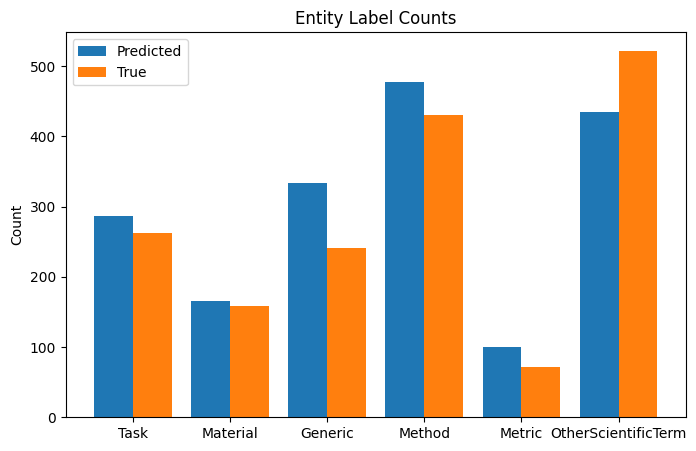

In [15]:
import matplotlib.pyplot as plt

# Merge and map predicted labels
entity_labels_count_predicted_mapped = {
    'Task': entity_labels_predicted_count.get('Task', 0),
    'Material': entity_labels_predicted_count.get('Material', 0)+ entity_labels_predicted_count.get('Tools',0)+entity_labels_predicted_count.get('Datasets',0),
    'Generic': entity_labels_predicted_count.get('Organisation', 0) + entity_labels_predicted_count.get('Person', 0)+entity_labels_predicted_count.get('Location',0),
    'Method': entity_labels_predicted_count.get('Method', 0) + entity_labels_predicted_count.get('Models', 0),
    'Metric': entity_labels_predicted_count.get('Metric',0),
    'OtherScientificTerm': entity_labels_predicted_count.get('Corpus',0)+entity_labels_predicted_count.get('quantity',0)+entity_labels_predicted_count.get('Language',0)
}

# True labels are already in the correct format
entity_labels_count_true_mapped = entity_labels_true_count

labels = ['Task', 'Material', 'Generic', 'Method','Metric','OtherScientificTerm']
counts_pred = [entity_labels_count_predicted_mapped.get(l, 0) for l in labels]
counts_true = [entity_labels_count_true_mapped.get(l, 0) for l in labels]

x = range(len(labels))
plt.figure(figsize=(8, 5))
plt.bar(x, counts_pred, width=0.4, label='Predicted', align='center')
plt.bar([i + 0.4 for i in x], counts_true, width=0.4, label='True', align='center')
plt.xticks([i + 0.2 for i in x], labels)
plt.ylabel('Count')
plt.title('Entity Label Counts')
plt.legend()
plt.show()

In [16]:
results[6]

['several kinds', 'dictionaries', 'segment and tag', 'Japanese']

In [17]:
true=[]
for i in range(len(new_data)):
    temp=[]
    for j in new_data[i]['ner']:
        temp.append(j[2])
    true.append(temp)

In [18]:
results[2]

['LRB', 'Japanese', 'Multi-lingual Evaluation Task', 'RRB', 'Our approach']

In [19]:
new_data[0]['ner']

[[0, 3, 'Recognition of proper nouns', 'Task'],
 [2, 3, 'proper nouns', 'OtherScientificTerm'],
 [5, 6, 'Japanese text', 'Material'],
 [19, 20, 'morphological analysis', 'Task'],
 [22, 24, 'Japanese text processing', 'Task']]

In [20]:
pred_ner[0]

[[0, 0, 'Task', 'Recognition'],
 [5, 5, 'Language', 'Japanese'],
 [19, 20, 'Task', 'morphological analysis']]

In [21]:
true[2]

['approach',
 'Multi-lingual Evaluation Task -LRB- MET -RRB-',
 'Japanese text',
 'task',
 'morphological analysis problem',
 'Japanese']

In [22]:
their=0
ours=0
common=0
for i in range(len(results)):
    their+=len(set(true[i]))
    ours+=len(set(results[i]))
    common+=len(set(true[i]).intersection(set(results[i])))

In [23]:
their,ours,common

(1673, 1685, 625)

In [24]:
recall_avg=[]
precision_avg=[]
common2=0
for i in range(len(results)):
    true_set=set(true[i])
    pred_set=set(results[i])
    
    if len(true_set) == 0 and len(pred_set) == 0:
        recall_avg.append(1.0)
        precision_avg.append(1.0)
    else:
        count=0
        for m in true_set:
            for n in pred_set:
                if m in n or n in m:
                    count+= 1
        recall = count / len(true_set) if len(true_set) > 0 else 0
        precision = count / len(pred_set) if len(pred_set) > 0 else 0
        common2 += count
        recall_avg.append(recall)
        precision_avg.append(precision)

In [25]:
common2

1194

In [26]:
sum(recall_avg) / len(recall_avg), sum(precision_avg) / len(precision_avg)

(0.7115198473637674, 0.6909615994008015)

In [27]:
true[11]

['anisotropic meshing',
 'non-quadratic approach',
 'regularization',
 'reconstruction',
 'triangulations',
 'vertices']

In [28]:
results[11]

['triangulations',
 'satisfactory reconstruction results',
 'non-quadratic approach',
 'anisotropic meshing',
 'regularization',
 'few vertices']

In [29]:
recall_avg

[0.8,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.6666666666666666,
 0.0,
 0.0,
 0.25,
 0.6666666666666666,
 1.0,
 0.6666666666666666,
 0.25,
 0.5,
 0.6666666666666666,
 0.6666666666666666,
 0.3333333333333333,
 0.6666666666666666,
 0.0,
 1.6666666666666667,
 2.0,
 0.6666666666666666,
 0.5,
 1.0,
 0.0,
 1.0,
 1.0,
 1.25,
 0.25,
 0.6666666666666666,
 0.5,
 0.3333333333333333,
 0.6666666666666666,
 1.25,
 0.16666666666666666,
 1.0,
 0.3333333333333333,
 0.0,
 1.0,
 1.3333333333333333,
 0.5714285714285714,
 0.8,
 0.8333333333333334,
 0.8,
 1.0,
 0.16666666666666666,
 1.0,
 0.7142857142857143,
 0.0,
 0.14285714285714285,
 1.0,
 1.0,
 1.0,
 1.0,
 0.6666666666666666,
 0.75,
 0.0,
 0.3333333333333333,
 0.8333333333333334,
 0,
 0.5,
 1.0,
 0.5,
 1.0,
 1.25,
 0.6666666666666666,
 0.0,
 0.0,
 1.0,
 0.0,
 0.3333333333333333,
 0.5,
 1.0,
 0.4,
 0.5,
 0.0,
 1.0,
 1.0,
 1.0,
 0.8333333333333334,
 0.6666666666666666,
 1.0,
 1.5,
 2.0,
 0.75,
 1.0,
 1.0,
 0.5,
 0.6,
 0.4,
 0.4,
 0.4,
 1.0,
 0.5,
 0.6666666666666

In [30]:

for i in range(len(new_data)):
    for j in range(len(new_data[i]['ner'])):
        new_data[i]['ner'][j][2],new_data[i]['ner'][j][3] = new_data[i]['ner'][j][3], new_data[i]['ner'][j][2]

In [31]:
new_data[0]['ner']

[[0, 3, 'Task', 'Recognition of proper nouns'],
 [2, 3, 'OtherScientificTerm', 'proper nouns'],
 [5, 6, 'Material', 'Japanese text'],
 [19, 20, 'Task', 'morphological analysis'],
 [22, 24, 'Task', 'Japanese text processing']]

In [32]:
new_data[0]['sentence']

['Recognition',
 'of',
 'proper',
 'nouns',
 'in',
 'Japanese',
 'text',
 'has',
 'been',
 'studied',
 'as',
 'a',
 'part',
 'of',
 'the',
 'more',
 'general',
 'problem',
 'of',
 'morphological',
 'analysis',
 'in',
 'Japanese',
 'text',
 'processing',
 '-LRB-',
 '-LSB-',
 '1',
 '-RSB-',
 '-LSB-',
 '2',
 '-RSB-',
 '-RRB-',
 '.']

In [33]:
new_data[59]['relations']

[['point correspondences', 'estimation of the tensors', 'USED-FOR'],
 ['factorization', 'tensors', 'USED-FOR'],
 ['line correspondences', 'estimation', 'USED-FOR']]

In [34]:
new_data[59]['ner']

[[6, 9, 'Task', 'estimation of the tensors'],
 [9, 9, 'Generic', 'tensors'],
 [11, 12, 'OtherScientificTerm', 'point correspondences'],
 [16, 16, 'Method', 'factorization'],
 [21, 21, 'Generic', 'estimation'],
 [23, 24, 'OtherScientificTerm', 'line correspondences']]

In [35]:
final={}
rel_count={}
for i in range(len(new_data)):
    mapp={}
    for j in new_data[i]['ner']:
        mapp[j[3]]=j[2]
    for j in new_data[i]['relations']:
        if j[2] not in rel_count:
            rel_count[j[2]] = 0
        rel_count[j[2]] += 1
        if j[2] not in final:
            final[j[2]] = set()
        final[j[2]].add((mapp[j[0]], mapp[j[1]]))

In [36]:
final

{'PART-OF': {('Generic', 'Method'),
  ('Generic', 'OtherScientificTerm'),
  ('Material', 'Generic'),
  ('Material', 'Material'),
  ('Material', 'OtherScientificTerm'),
  ('Method', 'Generic'),
  ('Method', 'Method'),
  ('OtherScientificTerm', 'Generic'),
  ('OtherScientificTerm', 'Material'),
  ('OtherScientificTerm', 'Method'),
  ('OtherScientificTerm', 'OtherScientificTerm'),
  ('OtherScientificTerm', 'Task'),
  ('Task', 'Generic'),
  ('Task', 'Task')},
 'USED-FOR': {('Generic', 'Generic'),
  ('Generic', 'Material'),
  ('Generic', 'Method'),
  ('Generic', 'Metric'),
  ('Generic', 'OtherScientificTerm'),
  ('Generic', 'Task'),
  ('Material', 'Generic'),
  ('Material', 'Method'),
  ('Material', 'OtherScientificTerm'),
  ('Material', 'Task'),
  ('Method', 'Generic'),
  ('Method', 'Material'),
  ('Method', 'Method'),
  ('Method', 'Metric'),
  ('Method', 'OtherScientificTerm'),
  ('Method', 'Task'),
  ('Metric', 'Generic'),
  ('Metric', 'Method'),
  ('Metric', 'Metric'),
  ('Metric', 'Oth

In [37]:
rel_count

{'PART-OF': 63,
 'USED-FOR': 533,
 'HYPONYM-OF': 67,
 'CONJUNCTION': 123,
 'FEATURE-OF': 59,
 'EVALUATE-FOR': 91,
 'COMPARE': 38}

In [38]:
from pair2rel import Pair2Rel

rel_model = Pair2Rel.from_pretrained("chapalavamshi022/pair2rel")

rel_model = rel_model.to(device)

labels=['USED-FOR','AND', 'EVALUATE-FOR', 'FEATURE-OF', 'PART-OF','COMPARE']

relations_all=[]
# head_asset={'Peop':'Org','Peop':'Loc','Org':'Loc','Loc':'Loc','Peop':'Peop'}
for i in tqdm(range(len(new_data))):
    if new_data[i]['ner'] == []:
        relations_all.append([])
        continue

    relations = rel_model.predict_relations(new_data[i]['sentence'], labels, threshold=0.0, ner=new_data[i]['ner'], top_k=1)
    mapp={}
    order={}
    for j in new_data[i]['ner']:
        mapp[j[3]]=j[2]
        order[j[3]]=j[0]

    sorted_data_desc = sorted(relations, key=lambda x: x['score'], reverse=True)
    temp=[]
    for item in sorted_data_desc:
        head=' '.join(item['head_text'])
        tail=' '.join(item['tail_text'])
        if head in mapp and tail in mapp and head!=tail:
            temp.append([head,tail,item['label']])
    relations_all.append(temp)
        
print("Success! ✅")

/home/bt19d200/NER_Vamshi/NER_Model/.conda/lib/python3.10/site-packages/transformers/convert_slow_tokenizer.py:561: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
100%|██████████| 551/551 [00:52<00:00, 10.44it/s]

Success! ✅


In [39]:
new_data[0]['ner']

[[0, 3, 'Task', 'Recognition of proper nouns'],
 [2, 3, 'OtherScientificTerm', 'proper nouns'],
 [5, 6, 'Material', 'Japanese text'],
 [19, 20, 'Task', 'morphological analysis'],
 [22, 24, 'Task', 'Japanese text processing']]

In [40]:
new_data[0]['relations']

[['Recognition of proper nouns', 'morphological analysis', 'PART-OF'],
 ['proper nouns', 'Japanese text', 'PART-OF'],
 ['morphological analysis', 'Japanese text processing', 'USED-FOR']]

In [41]:
relations_true=[]
for i in range(len(new_data)):
    
    relations_true.append(new_data[i]['relations'])

In [42]:
' '.join(new_data[0]['sentence'])

'Recognition of proper nouns in Japanese text has been studied as a part of the more general problem of morphological analysis in Japanese text processing -LRB- -LSB- 1 -RSB- -LSB- 2 -RSB- -RRB- .'

In [43]:
relations_true[2]

[['approach', 'Multi-lingual Evaluation Task -LRB- MET -RRB-', 'USED-FOR'],
 ['Multi-lingual Evaluation Task -LRB- MET -RRB-',
  'Japanese text',
  'USED-FOR'],
 ['morphological analysis problem', 'task', 'USED-FOR'],
 ['Japanese', 'morphological analysis problem', 'USED-FOR']]

In [45]:
recall_avg=[]
precision_avg=[]
common=0
ours=0
relations_all_filtered=[]

for i in range(len(relations_all)):
    true_set=relations_true[i]
    pred_set=relations_all[i]
    d={}
    temp=[]
    for item in pred_set:
        if (item[0],item[1]) not in d and (item[1],item[0]) not in d:
            d[(item[0],item[1])]=item[2]
            temp.append([item[0],item[1],item[2]])
    relations_all_filtered.append(temp)
    
    ours+=len(d)
    if len(true_set) == 0 and len(pred_set) == 0:
        recall_avg.append(1.0)
        precision_avg.append(1.0)
    else:
        count=0
        for m in true_set:
            for n in pred_set:
                if m[0]==n[0] and m[1]==n[1] and (m[2]==n[2] or (m[2]=='CONJUNCTION' and n[2]=='AND')):
                    count+= 1
        recall = count/ len(true_set) if len(true_set) > 0 else 0
        precision = count / len(d) if len(d) > 0 else 0
        common += count
        recall_avg.append(recall)
        precision_avg.append(precision)

In [46]:
sum(recall_avg) / len(recall_avg), sum(precision_avg) / len(precision_avg)

(0.5034851365613614, 0.37222532458467134)

In [47]:
relations_labels_predicted_count={}
relations_labels_true_count={}
for i in range(len(relations_all)):
    for j in relations_all_filtered[i]:
        
        if j[2] not in relations_labels_predicted_count:
            if j[2]=='AND' and 'CONJUNCTION' not in relations_labels_predicted_count:
                relations_labels_predicted_count['CONJUNCTION']=0
            elif j[2]!='AND':
                relations_labels_predicted_count[j[2]]=0
        if j[2]=='AND':
            relations_labels_predicted_count['CONJUNCTION']+=1
        else:
            relations_labels_predicted_count[j[2]]+=1
        
    for j in relations_true[i]:
        if j[2] not in relations_labels_true_count:
            relations_labels_true_count[j[2]]=0
        relations_labels_true_count[j[2]]+=1
        

In [48]:
relations_labels_predicted_count

{'PART-OF': 223,
 'USED-FOR': 1128,
 'EVALUATE-FOR': 39,
 'FEATURE-OF': 765,
 'COMPARE': 214,
 'CONJUNCTION': 116}

In [49]:
relations_labels_true_count

{'PART-OF': 63,
 'USED-FOR': 533,
 'HYPONYM-OF': 67,
 'CONJUNCTION': 123,
 'FEATURE-OF': 59,
 'EVALUATE-FOR': 91,
 'COMPARE': 38}

In [50]:
' '.join(new_data[13]['sentence'])

'They improve the reconstruction results and enforce their consistency with a priori knowledge about object shape .'

In [51]:
relations_all[13]

[['They', 'reconstruction', 'USED-FOR'],
 ['reconstruction', 'They', 'USED-FOR'],
 ['object shape', 'They', 'USED-FOR'],
 ['They', 'object shape', 'USED-FOR'],
 ['priori knowledge', 'They', 'USED-FOR'],
 ['They', 'priori knowledge', 'USED-FOR'],
 ['object shape', 'reconstruction', 'USED-FOR'],
 ['reconstruction', 'object shape', 'USED-FOR'],
 ['priori knowledge', 'reconstruction', 'USED-FOR'],
 ['reconstruction', 'priori knowledge', 'USED-FOR'],
 ['priori knowledge', 'object shape', 'USED-FOR'],
 ['object shape', 'priori knowledge', 'USED-FOR']]

In [52]:
relations_true[13]

[['They', 'reconstruction', 'USED-FOR'],
 ['object shape', 'priori knowledge', 'FEATURE-OF']]

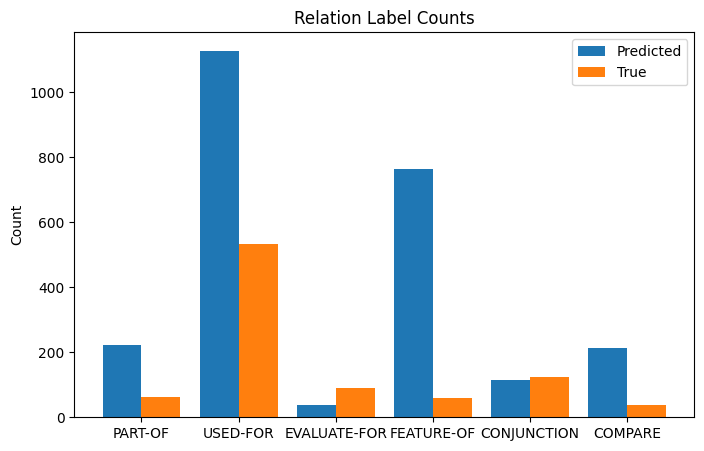

In [53]:
import matplotlib.pyplot as plt

labels = ['PART-OF', 'USED-FOR', 'EVALUATE-FOR', 'FEATURE-OF', 'CONJUNCTION', 'COMPARE']
counts_pred = [relations_labels_predicted_count.get(l, 0) for l in labels]
counts_true = [relations_labels_true_count.get(l, 0) for l in labels]

x = range(len(labels))
plt.figure(figsize=(8, 5))
plt.bar(x, counts_pred, width=0.4, label='Predicted', align='center')
plt.bar([i + 0.4 for i in x], counts_true, width=0.4, label='True', align='center')
plt.xticks([i + 0.2 for i in x], labels)
plt.ylabel('Count')
plt.title('Relation Label Counts')
plt.legend()
plt.show()

In [54]:
their=0
for i in range(len(relations_all)):
    their+=len(relations_true[i])
    

In [55]:
their,ours,common

(974, 2485, 384)

In [57]:
from pair2rel import Pair2Rel

rel_model = Pair2Rel.from_pretrained("chapalavamshi022/pair2rel")

rel_model = rel_model.to(device)

labels=['USED-FOR','AND', 'EVALUATE-FOR', 'FEATURE-OF', 'PART-OF','COMPARE']

relations_all=[]
# head_asset={'Peop':'Org','Peop':'Loc','Org':'Loc','Loc':'Loc','Peop':'Peop'}
for i in tqdm(range(len(new_data))):
    if new_data[i]['ner'] == []:
        relations_all.append([])
        continue
    try:
        relations = rel_model.predict_relations(new_data[i]['sentence'], labels, threshold=0.0, ner=pred_ner[i], top_k=1)
        mapp={}
        order={}
        for j in new_data[i]['ner']:
            mapp[j[3]]=j[2]
            order[j[3]]=j[0]

        sorted_data_desc = sorted(relations, key=lambda x: x['score'], reverse=True)
        temp=[]
        for item in sorted_data_desc:
            head=' '.join(item['head_text'])
            tail=' '.join(item['tail_text'])
            if head in mapp and tail in mapp and head!=tail:
                temp.append([head,tail,item['label']])
        relations_all.append(temp)
    except:
        relations_all.append([])
        
print("Success! ✅")

/home/bt19d200/NER_Vamshi/NER_Model/.conda/lib/python3.10/site-packages/transformers/convert_slow_tokenizer.py:561: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
100%|██████████| 551/551 [00:46<00:00, 11.89it/s]

Success! ✅


In [60]:
recall_avg=[]
precision_avg=[]
common=0
ours=0
relations_all_filtered=[]

for i in range(len(relations_all)):
    true_set=relations_true[i]
    pred_set=relations_all[i]
    d={}
    temp=[]
    for item in pred_set:
        if (item[0],item[1]) not in d and (item[1],item[0]) not in d:
            d[(item[0],item[1])]=item[2]
            temp.append([item[0],item[1],item[2]])
    relations_all_filtered.append(temp)
    
    ours+=len(d)
    if len(true_set) == 0 and len(pred_set) == 0:
        recall_avg.append(1.0)
        precision_avg.append(1.0)
    else:
        count=0
        for m in true_set:
            for n in pred_set:
                if (m[0] in n[0] or n[0] in m[0]) and (m[1] in n[1] or n[1] in m[1]) and (m[2]==n[2] or (m[2]=='CONJUNCTION' and n[2]=='AND')):
                    count+= 1
        recall = count/ len(true_set) if len(true_set) > 0 else 0
        precision = count / len(d) if len(d) > 0 else 0
        common += count
        recall_avg.append(recall)
        precision_avg.append(precision)

In [61]:
sum(recall_avg) / len(recall_avg), sum(precision_avg) / len(precision_avg)

(0.3167494886641893, 0.3320024198427103)